In [1]:
import random, shutil

import torch as th
import pytorch_lightning as ptl
import torchmetrics as thm

import skimage as ski
import torchvision as tv

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 12)

In [2]:
datadir = os.path.realpath('../data/cifar/cifar-10/')

In [3]:
train_files = (
    'data_batch_1',
    'data_batch_2',
    'data_batch_3',
    'data_batch_4',
)

val_files = (
    'data_batch_5',
)

test_files = (
    'test_batch'
)

In [4]:
class_names = (
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
)

class_index = {i: class_name for i, class_name in enumerate(class_names)}
class_index

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [5]:
def load_batch(filename):                                                                       
    with open(filename, mode='rb') as fh:                                                           
        batch_info_bytes = pickle.load(fh, encoding='bytes')                                        
        batch_info = {key.decode('ascii'): value                                                    
                      for key, value in batch_info_bytes.items()}                                   
                                                                                                    
    data, labels = batch_info['data'], batch_info['labels']                                         
                                                                                                    
    data = data.reshape((-1, 3, 32, 32))                                                            
    labels = np.asarray(labels, dtype=np.int64)                                                     
                                                                                                    
    data = np.moveaxis(data, 1, -1)                                                                 
                                                                                                    
    return data, labels                                                                             
                           

In [6]:
def load_data(batchfiles):                                                                 
    data, labels = [], []                                                                           
    for filename in batchfiles:                                                                     
        batch_data, batch_labels = load_batch(os.path.join(datadir, filename))                      
        data.append(batch_data)                                                                     
        labels.append(batch_labels)                                                                 
                                                                                                    
    return np.concatenate(data), np.concatenate(labels)                                             

(40000, 32, 32, 3)
(40000,)


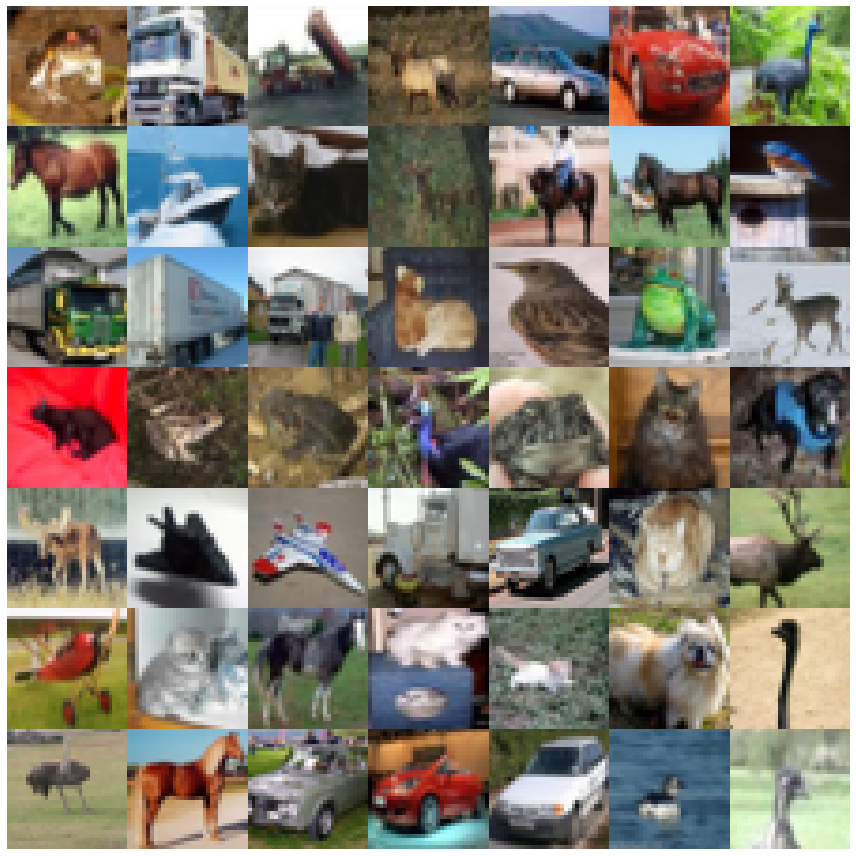

In [7]:
data, labels = load_data(train_files)
print(data.shape)
print(labels.shape)                                                                         

montage = ski.util.montage(data[:49], multichannel=True)                                        

plt.imshow(montage);                                                  
plt.axis('off');
plt.tight_layout();

# Dataset

In [8]:
class CIFARDataset(th.utils.data.Dataset):
    def __init__(self, datadir, filenames, transform=None):
        self.images, self.labels = self._load_data(datadir, filenames)
        self.transform = transform

    def _load_data(self, datadir, filenames):
        images_list, labels_list = [], []
        for filename in filenames:
            batch_images, batch_labels = self._load_data_file(
                os.path.join(datadir, filename))
            
            images_list.append(batch_images)
            labels_list.append(batch_labels)

        images = th.cat(images_list, dim=0)
        labels = th.cat(labels_list, dim=0)
        assert images.shape[0] == labels.shape[0]
        
        return images, labels

    @staticmethod
    def _load_data_file(filename):
        with open(filename, mode='rb') as fh:
            batch_info_bytes = pickle.load(fh, encoding='bytes')
            batch_info = {key.decode('ascii'): value
                          for key, value in batch_info_bytes.items()}

        images, labels = batch_info['data'], batch_info['labels']

        images = images.reshape((-1, 3, 32, 32))
        images = np.array([ski.img_as_float32(img) for img in images])
        images = th.as_tensor(images, dtype=th.float32)
        labels = th.as_tensor(labels, dtype=th.int64)

        return images, labels
    
    def plot_montage(self, n=49, seed=42):
        rng = random.Random(seed)
        idxs = rng.sample(range(len(self)), n)
        images, _labels = self[idxs]
        
        np_images = np.moveaxis(images.numpy(), -3, -1)
        print(np_images.shape)

        montage = ski.util.montage(np_images, multichannel=True)
        fig, ax = plt.subplots()
        ax.imshow(montage, interpolation='none')
        ax.axis('off')
        fig.tight_layout()
    
    def __getitem__(self, idx):
        images, labels = self.images[idx], self.labels[idx]
        if self.transform:
            images = self.transform(images)

        return self.images[idx], self.labels[idx]
    
    def __len__(self):
        return self.images.shape[0]

In [9]:
sample_data = CIFARDataset(datadir, train_files)

(49, 32, 32, 3)


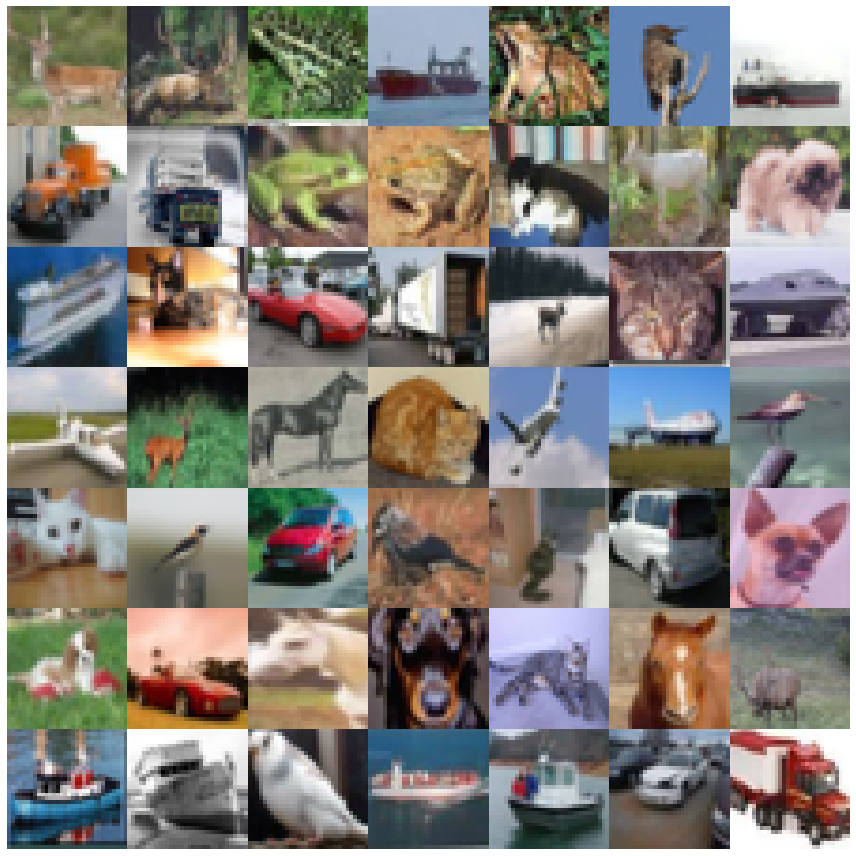

In [10]:
sample_data.plot_montage()

# Data Module

In [11]:
class CIFARData(ptl.LightningDataModule):
    def __init__(self, batch_size=800, num_workers=10):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
    
    def setup(self, stage=None):
        if stage == 'fit':
            self.train_data = CIFARDataset(
                datadir, train_files,
                transform=tv.transforms.RandomHorizontalFlip(0.5))
            
            self.val_data = CIFARDataset(datadir, val_files)
        elif stage == 'test':
            self.test_data = CIFARDataset(datadir, test_files)
        else:
            raise NotImplementedError(f'Stage {stage} is not implemented.')
    
    def train_dataloader(self):
        return th.utils.data.DataLoader(
            self.train_data,
            batch_size=self.batch_size,
            pin_memory=True,
            num_workers=self.num_workers,
            drop_last=True,
            shuffle=True)
    
    def val_dataloader(self):
        return th.utils.data.DataLoader(
            self.val_data,
            batch_size=self.batch_size,
            pin_memory=True,
            num_workers=self.num_workers,
            drop_last=False,
            shuffle=False)
    
    def test_dataloader(self):
        return th.utils.data.DataLoader(
            self.test_data,
            batch_size=self.batch_size,
            pin_memory=True,
            num_workers=self.num_workers,
            drop_last=False,
            shuffle=False)

In [12]:
cifar_data = CIFARData()

# Networks

In [13]:
class CIFARNetwork(ptl.LightningModule):
    def __init__(self):
        super().__init__()
        self.loss_func = th.nn.CrossEntropyLoss()
        self.train_acc = thm.Accuracy(num_classes=10, average='micro', compute_on_step=True)
        self.val_acc = thm.Accuracy(num_classes=10, average='micro', compute_on_step=False)
        self.val_acc_macro = thm.Accuracy(num_classes=10, average=None, compute_on_step=False)
        self.example_input_array = th.rand(8, 3, 32, 32)

    def configure_optimizers(self):
        parameters = list(filter(lambda params: params.requires_grad, self.parameters()))
        return th.optim.Adam(parameters, lr=0.0015)
    
    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        loss = self.loss_func(logits, labels)
        
        self.log('train_loss_step', loss, on_step=True, on_epoch=False)
        self.log_dict({'step': self.current_epoch, 'train_loss_epoch': loss},
                 on_step=False, on_epoch=True)

        preds = logits.argmax(1)
        train_acc_step = self.train_acc(preds, labels)
        self.log('train_acc_step', train_acc_step, on_step=True, on_epoch=False)

        return {'loss': loss}
    
    def training_epoch_end(self, outputs):
        self.log_dict({
            'step': self.current_epoch,
            'train_acc_epoch': self.train_acc.compute(),
        })

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        loss = self.loss_func(logits, labels)

        self.log_dict({'step': self.current_epoch, 'val_loss_epoch': loss})
        
        preds = logits.argmax(1)
        self.val_acc(preds, labels)
        self.val_acc_macro(preds, labels)

        return {'loss': loss}
    
    def validation_epoch_end(self, outputs):
        self.log_dict({
            'step': self.current_epoch,
            'val_acc_epoch': self.val_acc.compute(),
        }, prog_bar=True)
        
        acc_macro = {class_name: acc
                     for class_name, acc in zip(class_names, self.val_acc_macro.compute())}
        self.log_dict({
            'step': self.current_epoch,
            'val_acc_micro': acc_macro,
        })

## Good-old logistic regression

In [14]:
class LogisticRegression(CIFARNetwork):
    def __init__(self, nchan=3, height=32, width=32, nclass=10, **kwargs):
        super().__init__(**kwargs)
        
        self.nchan = nchan
        self.height = height
        self.width = width
        self.nclass = nclass
        
        self.visible = th.nn.Linear(self.height * self.width * self.nchan, self.nclass)
        
    def forward(self, imgs):
        assert imgs.ndim == 4
        assert imgs.shape[1:] == (self.nchan, self.height, self.width), imgs.shape
        batch_size = imgs.shape[0]
        
        imgs_flat = imgs.view(batch_size, -1)
        assert imgs_flat.shape == (batch_size, self.nchan * self.height * self.width)
        
        visible_out = self.visible(imgs_flat)
        assert visible_out.shape == (batch_size, self.nclass)
        
        return visible_out

In [15]:
logreg = LogisticRegression()

# Trainer

In [16]:
logdir = 'cifar_lightning_logs'
shutil.rmtree(logdir)

In [17]:
logger = ptl.loggers.TensorBoardLogger(logdir, name='logreg', log_graph=True)

In [18]:
callbacks = [
    ptl.callbacks.early_stopping.EarlyStopping(monitor='val_acc_epoch', patience=10, mode='max', verbose=True),
]

In [19]:
trainer = ptl.Trainer(
    logger=logger,
    default_root_dir=logdir,
    max_epochs=50,
    callbacks=callbacks,
    log_every_n_steps=1,
    check_val_every_n_epoch=1,
    progress_bar_refresh_rate=1,
    gpus=[1,])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [20]:
trainer.fit(logreg, cifar_data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
<ipython-input-14-7d2d22397c35>:14: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert imgs.shape[1:] == (self.nchan, self.height, self.width), imgs.shape
<ipython-input-14-7d2d22397c35>:18: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert imgs_flat.shape == (batch_size, self.nchan * self.height * self.width)
<ipython-input-14-7d2d22397c35>:21: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will 

Validation sanity check: 0it [00:00, ?it/s]

Traceback (most recent call last):
  File "/usr/lib64/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib64/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib64/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib64/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved. New best score: 0.296


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.023 >= min_delta = 0.0. New best score: 0.319


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.014 >= min_delta = 0.0. New best score: 0.333


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.008 >= min_delta = 0.0. New best score: 0.341


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.004 >= min_delta = 0.0. New best score: 0.345


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.004 >= min_delta = 0.0. New best score: 0.350


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.003 >= min_delta = 0.0. New best score: 0.353


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.003 >= min_delta = 0.0. New best score: 0.356


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.004 >= min_delta = 0.0. New best score: 0.359


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.003 >= min_delta = 0.0. New best score: 0.362


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.002 >= min_delta = 0.0. New best score: 0.364


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.365


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.365


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.002 >= min_delta = 0.0. New best score: 0.367


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.368


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.370


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.371


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.372


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.373


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.374


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.374


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.375


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.375


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.376


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.377


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.378


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.378


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.379


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.379


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.380


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.380


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.381


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.381


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.381


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.381


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.382


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.382


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.382


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.382


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.383


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.383


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.383


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.383


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.384


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.384


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.384


## Dense Neural Net

In [21]:
class DenseNet(CIFARNetwork):
    def __init__(self, nchan=3, height=32, width=32, nhiddens=(256, 128, 64, 32), nclass=10, **kwargs):
        super().__init__(**kwargs)
        
        self.nchan = nchan
        self.height = height
        self.width = width
        self.nhiddens = nhiddens
        self.nclass = nclass
        
        layer_in, layer_out = None, self.nchan * self.height * self.width
        hiddens = []
        for nhidden in self.nhiddens:
            layer_in, layer_out = layer_out, nhidden
            hiddens.extend([
                th.nn.BatchNorm1d(layer_in),
                th.nn.Linear(layer_in, layer_out),
                th.nn.Tanh(),
            ])
        self.hiddens = th.nn.Sequential(*hiddens)
        
        layer_in, layer_out = layer_out, self.nclass
        self.visible = th.nn.Linear(layer_in, layer_out)
        
    def forward(self, imgs):
        assert imgs.ndim == 4
        assert imgs.shape[1:] == (self.nchan, self.height, self.width), imgs.shape
        batch_size = imgs.shape[0]
        
        imgs_flat = imgs.view(batch_size, -1)
        assert imgs_flat.shape == (batch_size, self.nchan * self.height * self.width)
        
        hidden_out = self.hiddens(imgs_flat)
        assert hidden_out.shape == (batch_size, self.nhiddens[-1])
        
        visible_out = self.visible(hidden_out)
        assert visible_out.shape == (batch_size, self.nclass)
        
        return visible_out

In [22]:
dense_net = DenseNet()

In [23]:
logger = ptl.loggers.TensorBoardLogger(logdir, name='dense_net', log_graph=True)

In [24]:
callbacks = [
    ptl.callbacks.early_stopping.EarlyStopping(monitor='val_acc_epoch', patience=10, mode='max', verbose=True),
]

In [25]:
trainer = ptl.Trainer(
    logger=logger,
    default_root_dir=logdir,
    max_epochs=50,
    callbacks=callbacks,
    log_every_n_steps=1,
    check_val_every_n_epoch=1,
    progress_bar_refresh_rate=1,
    gpus=[1,])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [26]:
trainer.fit(dense_net, cifar_data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
<ipython-input-21-499435613984>:27: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert imgs.shape[1:] == (self.nchan, self.height, self.width), imgs.shape
<ipython-input-21-499435613984>:31: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert imgs_flat.shape == (batch_size, self.nchan * self.height * self.width)
<ipython-input-21-499435613984>:34: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will 

Validation sanity check: 0it [00:00, ?it/s]

Traceback (most recent call last):
  File "/usr/lib64/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib64/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib64/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib64/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved. New best score: 0.338


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.034 >= min_delta = 0.0. New best score: 0.372


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.017 >= min_delta = 0.0. New best score: 0.389


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.013 >= min_delta = 0.0. New best score: 0.402


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.007 >= min_delta = 0.0. New best score: 0.410


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.008 >= min_delta = 0.0. New best score: 0.418


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.006 >= min_delta = 0.0. New best score: 0.424


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.005 >= min_delta = 0.0. New best score: 0.429


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.005 >= min_delta = 0.0. New best score: 0.433


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.004 >= min_delta = 0.0. New best score: 0.437


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.003 >= min_delta = 0.0. New best score: 0.440


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.003 >= min_delta = 0.0. New best score: 0.443


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.002 >= min_delta = 0.0. New best score: 0.445


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.002 >= min_delta = 0.0. New best score: 0.448


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.002 >= min_delta = 0.0. New best score: 0.449


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.002 >= min_delta = 0.0. New best score: 0.451


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.002 >= min_delta = 0.0. New best score: 0.453


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.002 >= min_delta = 0.0. New best score: 0.454


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.455


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.456


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.457


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.458


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.459


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.459


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.460


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.460


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.460


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.460


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.461


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.461


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.461


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.462


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.462


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.462


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.462


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.462


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.462


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_acc_epoch did not improve in the last 10 records. Best score: 0.462. Signaling Trainer to stop.


## Convolutional Neural Net

In [27]:
class ConvNet(CIFARNetwork):
    def __init__(self, nchan=3, height=32, width=32, conv_specs=((32, 3, 2), (64, 3, 2)),
                 nhidden=128, nclass=10, **kwargs):
        super().__init__(**kwargs)

        self.nchan = nchan
        self.height = height
        self.width = width
        self.conv_specs = conv_specs
        self.nhidden = nhidden
        self.nclass = nclass

        layer_in, layer_out = None, self.nchan
        convs = []
        for nfilt, kernel_size, stride in self.conv_specs:
            layer_in, layer_out = layer_out, nfilt
            convs.extend([
                th.nn.BatchNorm2d(layer_in),
                th.nn.Conv2d(
                    layer_in, layer_out,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=kernel_size // 2,
                ),
                th.nn.ReLU(),
            ])
        self.convs = th.nn.Sequential(*convs)

        # run a stub image to get size after convolutional layers
        stub_image = th.rand(8, self.nchan, self.height, self.width)
        convs_out = self.convs(stub_image)
        self.down_height, self.down_width = convs_out.shape[2], convs_out.shape[3]

        layer_in, layer_out = layer_out * self.down_height * self.down_width, self.nhidden
        self.hidden = th.nn.Sequential(
            th.nn.BatchNorm1d(layer_in),
            th.nn.Linear(layer_in, layer_out),
            th.nn.ReLU(),
        )
        
        layer_in, layer_out = layer_out, self.nclass
        self.visible = th.nn.Linear(layer_in, layer_out)
        
    def forward(self, imgs):
        assert imgs.ndim == 4
        assert imgs.shape[1:] == (self.nchan, self.height, self.width), imgs.shape
        batch_size = imgs.shape[0]
        
        convs_out = self.convs(imgs)
        assert convs_out.shape == (batch_size, self.conv_specs[-1][0],
                                   self.down_height, self.down_width)

        convs_flat = convs_out.view(batch_size, -1)
        hidden_out = self.hidden(convs_flat)
        assert hidden_out.shape == (batch_size, self.nhidden)
        
        visible_out = self.visible(hidden_out)
        assert visible_out.shape == (batch_size, self.nclass)
        
        return visible_out

In [28]:
dense_net = ConvNet(
    conv_specs=(
        (32,  7, 1),
        (32,  7, 2), # 16
        (64,  5, 1),
        (64,  5, 2), # 8
        (128, 3, 1),
        (128, 3, 2), # 4
    ),
    nhidden=256,
)

In [29]:
logger = ptl.loggers.TensorBoardLogger(logdir, name='dense_net', log_graph=True)

In [30]:
callbacks = [
    ptl.callbacks.early_stopping.EarlyStopping(monitor='val_acc_epoch', patience=10, mode='max', verbose=True),
]

In [31]:
trainer = ptl.Trainer(
    logger=logger,
    default_root_dir=logdir,
    max_epochs=50,
    callbacks=callbacks,
    log_every_n_steps=1,
    check_val_every_n_epoch=1,
    progress_bar_refresh_rate=1,
    gpus=[1,])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [32]:
trainer.fit(dense_net, cifar_data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
<ipython-input-27-902c57049178>:46: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert imgs.shape[1:] == (self.nchan, self.height, self.width), imgs.shape
<ipython-input-27-902c57049178>:50: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert convs_out.shape == (batch_size, self.conv_specs[-1][0],
<ipython-input-27-902c57049178>:55: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a

Validation sanity check: 0it [00:00, ?it/s]

Traceback (most recent call last):
  File "/usr/lib64/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib64/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib64/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib64/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved. New best score: 0.501


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.062 >= min_delta = 0.0. New best score: 0.564


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.039 >= min_delta = 0.0. New best score: 0.602


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.025 >= min_delta = 0.0. New best score: 0.627


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.019 >= min_delta = 0.0. New best score: 0.646


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.012 >= min_delta = 0.0. New best score: 0.658


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.008 >= min_delta = 0.0. New best score: 0.666


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.008 >= min_delta = 0.0. New best score: 0.674


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.006 >= min_delta = 0.0. New best score: 0.680


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.006 >= min_delta = 0.0. New best score: 0.685


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.005 >= min_delta = 0.0. New best score: 0.690


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.004 >= min_delta = 0.0. New best score: 0.694


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.004 >= min_delta = 0.0. New best score: 0.699


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.004 >= min_delta = 0.0. New best score: 0.702


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.004 >= min_delta = 0.0. New best score: 0.706


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.003 >= min_delta = 0.0. New best score: 0.709


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.003 >= min_delta = 0.0. New best score: 0.712


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.003 >= min_delta = 0.0. New best score: 0.715


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.002 >= min_delta = 0.0. New best score: 0.717


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.002 >= min_delta = 0.0. New best score: 0.720


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.002 >= min_delta = 0.0. New best score: 0.722


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.002 >= min_delta = 0.0. New best score: 0.723


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.002 >= min_delta = 0.0. New best score: 0.725


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.002 >= min_delta = 0.0. New best score: 0.727


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.728


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.729


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.731


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.732


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.733


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.734


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.735


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.736


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.736


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.737


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.738


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.739


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.739


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.740


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.741


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.741


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.742


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.001 >= min_delta = 0.0. New best score: 0.742


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.743


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.743


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.744


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.744


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.744


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.745


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.745


Validating: 0it [00:00, ?it/s]

Metric val_acc_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.746


In [33]:
%reload_ext tensorboard
%tensorboard --logdir cifar_lightning_logs